# MSc Simple Multi-Objective AutoML Pipeline

First I will look at 2 sets of data, 1 binary classification and one multiclass. I will do a complete pipeline and evaluation that will later be automated. That pipeline will include:

* Data Preprocessing
* Model Training
* Hyperparameter optimization.
* Model Evaluation with Accuracy
* Model Evaluation with Interpretability (specified metrics)
* Incorporating into a ranking function for model selection

Each automation will be constrained.

<img src="images\Pipeline.png"/>

Algorithms that will be used for modelling will be limited to:

1. Logistic Regression
2. Decision Trees
3. Random Forest
4. LightGBM
5. SVM

## Full Pipeline

In [2]:
# Importing the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform, randint, uniform
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import shap

# Import the algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [123]:
# Filter warnings
import warnings
import random

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning
)

#set global seed for reproducability
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Model and Hyperparameter grids

In [124]:
# Define models
models = {
    "logreg": LogisticRegression(max_iter=5000, random_state=SEED),
    "dt": DecisionTreeClassifier(random_state=SEED),
    "rf": RandomForestClassifier(n_jobs=-1, random_state=SEED),
    #"svm": SVC(probability=True), --> taken out due to speed of the experiments
    "lgb": LGBMClassifier(n_jobs=-1, random_state=SEED),
}

# Define parameter space

param_grids = {
    "logreg" : [ #Not all solvers are compatible with each type of regularization. so an list of dictionaries is implemented to enforce compatibility.
        {   # lbfgs: supports l2
            "model__solver": ["lbfgs"],
            "model__penalty": ["l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        {   # saga: supports elasticnet (needs l1_ratio)
            "model__solver": ["saga"],
            "model__penalty": ["elasticnet"],
            "model__C": loguniform(1e-4, 1e2),
            "model__l1_ratio": [0.1, 0.5, 0.9], #only used for elasticnet
            "model__class_weight": [None, "balanced"],
        },
        {   # saga can do l1 / l2 as well
            "model__solver": ["saga"],
            "model__penalty": ["l1", "l2"],
            "model__C": loguniform(1e-4, 1e2),
            "model__class_weight": [None, "balanced"],
        },
        ],

    "dt" : {
        "model__max_depth": randint(1, 20), 
        "model__min_samples_split": randint(2, 20), 
        "model__min_samples_leaf": randint(1, 20),
        "model__class_weight": [None, "balanced"],
    },
    "rf" : {
        "model__n_estimators": randint(100, 500),
        "model__max_depth": randint(1, 20),
        "model__min_samples_split": randint(2, 20),
        "model__class_weight": [None, "balanced", "balanced_subsample"],
    },
    #"svm" : [
    #    {
     #       "model__kernel": ["linear"],
     #       "model__C": loguniform(1e-3, 1e2),
     #       "model__class_weight": [None, "balanced"],
     #   },
     #   {
     #       "model__kernel": ["rbf"],
     #       "model__C": loguniform(1e-3, 1e2),
     #       "model__gamma": ["scale", "auto"],
     #       "model__class_weight": [None, "balanced"],
     #   }
    #],
    "lgb" : {
        "model__num_leaves": randint(31, 60),       # controls tree complexity
        "model__max_depth": randint(5, 15),         # limits tree depth
        "model__learning_rate": loguniform(1e-3, 0.1), # step size
        "model__n_estimators": randint(100, 500),   # number of boosting rounds
        "model__subsample": uniform(0.7, 0.3),      # row sampling
        "model__colsample_bytree": uniform(0.7, 0.3), # feature sampling
        "model__class_weight": [None, "balanced"], # to handle class imbalance
    }
}

### Import and Split Data

Telco Customer Churn:

https://www.kaggle.com/datasets/blastchar/telco-customer-churn 

In [125]:
# Import dataset
churn_data = pd.read_csv("Datasets/Telco-Customer-Churn.csv")

# Split the data into training and test sets

le = LabelEncoder()

y = le.fit_transform(churn_data["Churn"]) # encode category labels
X = churn_data.drop("Churn", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

In [126]:
len(y)

7043

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [128]:
churn_data["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [129]:
churn_data["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [130]:
np.unique(y, return_counts=True)

(array([0, 1]), array([5174, 1869]))

In [131]:
type(y)

numpy.ndarray

### Define Transformer class for pipeline

In [132]:
# Create a transformer class to group features in and drop columns

from sklearn.base import BaseEstimator, TransformerMixin

class GroupFeatures(BaseEstimator, TransformerMixin):

    # Constructor method
    def __init__(self, max_unique=20):
        self.max_unique = max_unique

    #Fit method learns column groupings and detects high cardinality 
    def fit(self, X, y=None):
        categorical = X.select_dtypes(include=["object", "string", "category"])
        numeric = X.select_dtypes(include="number")
        boolean = X.select_dtypes(include="bool")

        high_cardinality = categorical.nunique() > self.max_unique #Detects high cardinality above maximum value specified

        self.numeric_columns_ = numeric.columns.union(boolean.columns).tolist() #Creates numerical column list
        self.categorical_columns_ = high_cardinality[~high_cardinality].index.tolist() #Creates categorical column list - high cardinality features

        self.keep_columns_ = self.numeric_columns_ + self.categorical_columns_

        return self

    # passes through the data untransformed 
    def transform(self, X):
        return X[self.keep_columns_]

### Define Preprocessor

In [133]:
# ColumnTransformer for feature preprocessing
from sklearn.compose import make_column_selector

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), make_column_selector(dtype_include="number")), 
        ("cat", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=["object", "string", "category"])),
    ],
    remainder="drop"
).set_output(transform="default")

### Define Function for Hyperparameter Optimization using RandomizedSearchCV

In [134]:
# Function for randomized search cross validation search

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

def run_randomized_search(
    models,
    param_grids,
    X_train,
    y_train,
    preprocessor,
    feature_grouper_cls=GroupFeatures,
    feature_grouper_kwargs={"max_unique": 20},
    n_iter=20,
    n_splits=3,
    scoring=None,
    refit_metric="roc_auc",
    random_state=SEED,
    n_jobs=-1,
    verbose=True,
):
    """
    Runs RandomizedSearchCV for multiple models wrapped in a pipeline.

    Returns
    -------
    results : dict
        {model_name: fitted RandomizedSearchCV object}
    """

    if scoring is None:
        scoring = {
            "accuracy": "accuracy",
            "f1": "f1_weighted",
            "roc_auc": "roc_auc_ovr",
        }

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    results = {}
    search_times = {} # record search time per model

    for name, model in models.items():

        start_time = time.perf_counter()

        pipeline = Pipeline([
            ("features", feature_grouper_cls(**feature_grouper_kwargs)),
            ("preprocess", preprocessor),
            ("model", model),
        ])

        clf = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grids[name],
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            random_state=random_state,
            refit=refit_metric,
        )

        search = clf.fit(X_train, y_train)
        results[name] = search

        elapsed_time = time.perf_counter() - start_time
        search_times[name] = elapsed_time

        if verbose:
            best_idx = search.best_index_

            print("\n==============================")
            print(f"MODEL: {name}")
            print("==============================")
            print("Best Params:", search.best_params_)
            print(f"Best ROC-AUC:  {search.cv_results_['mean_test_roc_auc'][best_idx]:.4f}")
            print(f"Best Accuracy:{search.cv_results_['mean_test_accuracy'][best_idx]:.4f}")
            print(f"Best F1:      {search.cv_results_['mean_test_f1'][best_idx]:.4f}")

    return results, search_times

### Define function for model evaluation on test set

In [135]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model_on_test(best_pipeline, X_test, y_test):
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)
    
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"), # keeping multiclass metrics
    }

    #print("Unique classes in y_test:", np.unique(y_test))
    #print("Shape of y_proba:", y_proba.shape)
    #print("Classes learned by model:", best_pipeline.named_steps["model"].classes_)

    # ROC-AUC handling binary and multiclass
    n_classes = len(best_pipeline.named_steps["model"].classes_)
    
    if n_classes == 2:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba[:, 1]) # Binary
    else:
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro") # Multiclass
    
    return metrics, y_pred, y_proba

### Define SHAP stability function

In [136]:
def shap_stability_perturbations(
    best_pipeline,
    X_train,
    X_test,
    numerical_columns,
    n_background=100, #100-200
    n_samples=200, #200-300
    n_perturb=30, # 30-50
    max_evals = 200, # Limit model calls of SHAP per explanation
    noise_level=0.02, # 2% of train std
    random_state=SEED
):
    
    # Define cosine similarity inside function
    def cosine_similarity(a, b, eps=1e-12):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + eps)
    
    def topk_shap_sparsity(shap_values, k=5):
        """
        shap_values:
        binary: (n_samples, n_features)
        multiclass: (n_samples, n_features, n_classes)
        returns sparsity_per_sample (n_samples,)
        """
        shap_values = np.array(shap_values)
        
        # average absolute attributions across classes if multiclass
        if shap_values.ndim == 3:
            shap_values_abs = np.mean(np.abs(shap_values), axis=2)  # reduces to (n_samples, n_features)
        else:
            shap_values_abs = np.abs(shap_values)

        total = shap_values_abs.sum(axis=1) + 1e-12 # sum across all feature attributions per sample
        topk = np.sort(shap_values_abs, axis=1)[:, -k:].sum(axis=1) # sum attribution of top k features per sample 

        return topk / total # outputs local sparsity for each sample

    rng = np.random.default_rng(random_state)

    # Extract feature names from the pipeline for future conversion of transformed arrays back into DataFrames 
    feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()

    # Transform background data for masker
    X_train_background_raw = shap.sample(X_train, n_background, random_state=random_state) #first sample from training data so that preprocessing is done on fewer instances
    X_train_background_feat = best_pipeline.named_steps["features"].transform(X_train_background_raw)
    X_train_background_trans = best_pipeline.named_steps["preprocess"].transform(X_train_background_feat)

    #Create Masker
    masker = shap.maskers.Independent(X_train_background_trans)

    #Define final fitted model
    model = best_pipeline.named_steps["model"]
        
    #Create SHAP explainer
    explainer = shap.PermutationExplainer(model.predict_proba, masker)

    # Prepare test samples 
    X_explain_raw = shap.sample(X_test, n_samples, random_state=random_state)
    X_explain_feat = best_pipeline.named_steps["features"].transform(X_explain_raw)
    X_explain_trans = best_pipeline.named_steps["preprocess"].transform(X_explain_feat)

    # Calculate original SHAP values
    shap_orig = explainer(X_explain_trans, max_evals=max_evals).values  # shape: (n_samples, n_features, n_classes)

    # Calculate SHAP sparsity for shap_orig
    sparsity_scores = topk_shap_sparsity(shap_values=shap_orig)

    # Compute standard deviation for numeric columns 
    train_stds = X_train[numerical_columns].std(ddof=0).replace(0, 1e-12)

    # Perturb each sample K times, recompute SHAP, compute stability

    stability_scores = []

    for i in range(len(X_explain_raw)):
        x0 = X_explain_raw.iloc[i:i+1].copy() # make a copy of the sample

        # select the original shap vector for sample i
        s0 = shap_orig[i] # Shape: (n_features, n_classes)

        similarity_scores = []

        for _ in range(n_perturb):
            x_pert = x0.copy()

            # Ensuring numerical columns are float for compatible dtype when adding noise
            x_pert[numerical_columns] = x_pert[numerical_columns].astype(float)

            # add a small amount of noise to all numeric columns at once
            noise = rng.normal(loc=0.0, scale=noise_level * train_stds.values, size=(1, len(numerical_columns)))
            x_pert.loc[:, numerical_columns] = x_pert[numerical_columns].values + noise

            # Transform perturbed sample
            x_pert_feat = best_pipeline.named_steps["features"].transform(x_pert)
            x_pert_trans = best_pipeline.named_steps["preprocess"].transform(x_pert_feat)

            # calculate shap for perturbed sample
            shap_pert = explainer(x_pert_trans, max_evals=200).values[0]

            class_similarities = []

            for c in range(s0.shape[1]):
                similarity = cosine_similarity(s0[:,c], shap_pert[:,c])
                class_similarities.append((similarity + 1) / 2) # appending class similarity to list scaled between 0 and 1
        
            similarity_scores.append(np.mean(class_similarities)) #appends mean of similarity scores across classes to similarity scores

        # calculate the average stability score
        stability_scores.append(np.mean(similarity_scores))
    
    print(f"{model.__class__.__name__} SHAP analysis complete.")
    
    return np.array(stability_scores), np.array(sparsity_scores)

### Define Multi-Objective scoring function

In [86]:
# define scoring function
def multi_objective_score(performance, shap_stability, shap_sparsity, perf_ratio=0.5, interp_ratio = 0.5):
    assert 0 <= performance <= 1
    assert 0 <= shap_stability <= 1
    assert 0 <= shap_sparsity <= 1
    assert 0 <= perf_ratio <= 1
    assert 0 <= interp_ratio <= 1

    interp = interp_ratio * shap_stability + (1 - interp_ratio) * shap_sparsity

    return perf_ratio * performance + (1-perf_ratio) * interp

### Saving experiments

In [138]:
from pathlib import Path
from datetime import datetime
import json
import joblib
import numpy as np
import pandas as pd

def make_run_dir(base_dir="experiments", run_name=None):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = run_name or f"run_{ts}"
    run_dir = Path(base_dir) / run_name
    run_dir.mkdir(parents=True, exist_ok=True)
    (run_dir / "models").mkdir(exist_ok=True)
    (run_dir / "cv_results").mkdir(exist_ok=True)
    (run_dir / "preds").mkdir(exist_ok=True)
    (run_dir / "stability").mkdir(exist_ok=True)
    return run_dir

def save_json(obj, path: Path):
    # ensure numpy types are serializable
    def convert(o):
        if isinstance(o, (np.integer, np.int64)): return int(o)
        if isinstance(o, (np.floating, np.float64)): return float(o)
        if isinstance(o, (np.ndarray,)): return o.tolist()
        return str(o)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=convert)

def save_experiment(
    run_dir,
    results,        # dict: name -> RandomizedSearchCV (fitted)
    results_dict,   # dict: name -> {metrics, y_pred, y_proba, stability, ...}
    extra_metadata=None,
    compress=3,
):
    run_dir = Path(run_dir)

    # -------------------------
    # 1) Save everything quick (pickle)
    # -------------------------
    joblib.dump(results_dict, run_dir / "results_dict.joblib", compress=compress)

    # -------------------------
    # 2) Save best models
    # -------------------------
    for name, search in results.items():
        joblib.dump(search.best_estimator_, run_dir / "models" / f"{name}_best_pipeline.joblib", compress=compress)

    # -------------------------
    # 3) Save summary metrics (CSV)
    # -------------------------
    rows = []
    for name, d in results_dict.items():
        row = {"model": name}
        row["accuracy"] = float(d.get("accuracy", np.nan))
        row["f1_weighted"] = float(d.get("f1_weighted", np.nan))
        row["roc_auc"] = float(d.get("roc_auc", np.nan))
        row["mean_stability"] = float(d.get("mean_stability", np.nan))
        row["std_stability"]  = float(d.get("std_stability", np.nan))
        row["mean_sparsity"] = float(d.get("mean_sparsity", np.nan))
        row["std_sparsity"]  = float(d.get("std_sparsity", np.nan))
        row["ranking_score"] = float(d.get("ranking_score", np.nan))
        row["search_time_seconds"] = float(d.get("search_time_seconds", np.nan))
        row["shap_time_seconds"] = float(d.get("shap_time_seconds", np.nan))
        row["model_total_time_seconds"] = float(d.get("model_total_time_seconds", np.nan))
        row["full_automl_search_time_seconds"] = float(d.get("full_automl_search_time_seconds", np.nan))
        rows.append(row)
    df_summary = pd.DataFrame(rows).sort_values("ranking_score", ascending=False)
    df_summary.to_csv(run_dir / "experiment_summary.csv", index=False)

    # -------------------------
    # 4) Save raw CV results per model (CSV)
    # -------------------------
    for name, search in results.items():
        pd.DataFrame(search.cv_results_).to_csv(run_dir / "cv_results" / f"{name}_cv_results.csv", index=False)

    # -------------------------
    # 5) Save predictions/probas & stability vectors
    # -------------------------
    for name, d in results_dict.items():
        # predictions/probas
        y_pred = d.get("y_pred", None)
        y_proba = d.get("y_proba", None)

        if y_pred is not None:
            pd.DataFrame({"y_pred": np.asarray(y_pred)}).to_csv(run_dir / "preds" / f"{name}_y_pred.csv", index=False)

        if y_proba is not None:
            y_proba = np.asarray(y_proba)
            np.save(run_dir / "preds" / f"{name}_y_proba.npy", y_proba)  # best for arrays
            # optional CSV if you want:
            # pd.DataFrame(y_proba).to_csv(run_dir / "preds" / f"{name}_y_proba.csv", index=False)

        # stability
        stab = d.get("stability", None)
        if stab is not None:
            stab = np.asarray(stab)
            np.save(run_dir / "stability" / f"{name}_stability.npy", stab)
            pd.DataFrame({"stability": stab}).to_csv(run_dir / "stability" / f"{name}_stability.csv", index=False)

    # -------------------------
    # 6) Save metadata (JSON)
    # -------------------------
    meta = {
        "created": datetime.now().isoformat(),
        "models": list(results.keys()),
        "sklearn_version": __import__("sklearn").__version__,
    }
    # optional versions if installed
    try:
        import shap; meta["shap_version"] = shap.__version__
    except Exception:
        pass
    try:
        import lightgbm; meta["lightgbm_version"] = lightgbm.__version__
    except Exception:
        pass

    if extra_metadata:
        meta.update(extra_metadata)

    save_json(meta, run_dir / "metadata.json")

    return df_summary


## Implement full pipeline (Churn)

In [139]:
# For churn dataset

search_start = time.perf_counter() # initiate logging time

results, search_times = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train,
    y_train=y_train,
    preprocessor=preprocessor,
)

full_search_time = time.perf_counter() - search_start # Calculate full AutoML search time

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test,
        y_test=y_test)
    
    shap_start = time.perf_counter() # initiate logging time

    stability, sparsity = shap_stability_perturbations(
        best_pipeline,
        X_train,
        X_test,
        numerical_columns=numerical_columns,
        )
    
    shap_time = time.perf_counter() - shap_start # Calculate time taken for SHAP stability calculations for each model
    
    mean_stability = stability.mean()
    mean_sparsity = sparsity.mean()

    # Balanced score with perf_ratio and interp_ratio both 0.5
    ranking_score = multi_objective_score(performance=metrics['roc_auc'], shap_stability=mean_stability, shap_sparsity=mean_sparsity)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "mean_sparsity": mean_sparsity,
        "std_sparsity": sparsity.std(),
        "ranking_score": ranking_score,
        "search_time_seconds": search_times[name],
        "shap_time_seconds": shap_time,
        "model_total_time_seconds": search_times[name] + shap_time,
        "full_automl_search_time_seconds": full_search_time, # for randomized search not including shap
        }

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(6.015308718396457), 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best ROC-AUC:  0.8449
Best Accuracy:0.8037
Best F1:      0.7975

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 4, 'model__min_samples_leaf': 8, 'model__min_samples_split': 4}
Best ROC-AUC:  0.8280
Best Accuracy:0.7904
Best F1:      0.7837

MODEL: rf
Best Params: {'model__class_weight': None, 'model__max_depth': 8, 'model__min_samples_split': 17, 'model__n_estimators': 336}
Best ROC-AUC:  0.8446
Best Accuracy:0.8021
Best F1:      0.7917
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 44
[LightGBM] [Info] [binary:B

PermutationExplainer explainer: 201it [01:00,  2.77it/s]                         


RandomForestClassifier SHAP analysis complete.
LGBMClassifier SHAP analysis complete.


In [140]:
run_dir = make_run_dir(base_dir="experiments", run_name="telco_churn_seed42_v4")

df_summary = save_experiment(
    run_dir=run_dir,
    results=results,
    results_dict=results_dict,
    extra_metadata={
        "dataset": "telco_churn",
        "random_state": 42,
        "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
        "shap_settings": {"n_background": 100, "n_samples": 200, "n_perturb": 30, "noise_level": 0.02},
        "refit_metric": "roc_auc_ovr",
    }
)

df_summary

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
1,dt,0.792051,0.778335,0.830751,0.996505,0.005008,0.930958,0.038208,0.897242,1.026336,77.267708,78.294044,47.166513
3,lgb,0.751597,0.764394,0.842500,0.995442,0.003193,0.691606,0.058457,0.843012,20.811739,221.768268,242.580007,47.166513
0,logreg,0.794890,0.789852,0.838286,0.997089,0.002264,0.651425,0.037844,0.831271,15.756178,77.179862,92.936040,47.166513
2,rf,0.799148,0.789981,0.838922,0.997778,0.001352,0.543384,0.049986,0.804752,9.568409,1349.214546,1358.782955,47.166513


## Try on a multiclass dataset (Wine Quality)

Wine Quality Dataset

https://archive.ics.uci.edu/dataset/186/wine+quality 

In [141]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 

le_wine = LabelEncoder()

# data (as pandas dataframes) 
X_wine = wine_quality.data.features 
y_wine = le_wine.fit_transform(wine_quality.data.targets.squeeze())
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [142]:
len(y_wine)

6497

In [143]:
np.unique(le_wine.inverse_transform(y_wine))

array([3, 4, 5, 6, 7, 8, 9])

In [144]:
X_wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [145]:
X_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


In [146]:
# Split the data into training and test sets

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42, stratify=y_wine)

X_train_wine.shape, y_train_wine.shape, X_test_wine.shape, y_test_wine.shape

((5197, 11), (5197,), (1300, 11), (1300,))

In [147]:
# For wine quality

search_start = time.perf_counter() # initiate logging time

results, search_times = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train_wine, ## change
    y_train=y_train_wine, ## change
    preprocessor=preprocessor,
)

full_search_time = time.perf_counter() - search_start # Calculate full AutoML search time

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test_wine, ## change
        y_test=y_test_wine) ## change
    
    shap_start = time.perf_counter() # initiate logging time

    stability, sparsity = shap_stability_perturbations(
        best_pipeline,
        X_train_wine, ## Change
        X_test_wine, ## Change
        numerical_columns=numerical_columns,
        )
    
    shap_time = time.perf_counter() - shap_start # Calculate time taken for SHAP stability calculations for each model
    
    mean_stability = stability.mean()
    mean_sparsity = sparsity.mean()

    # Balanced score with perf_ratio and interp_ratio both 0.5
    ranking_score = multi_objective_score(performance=metrics['roc_auc'], shap_stability=mean_stability, shap_sparsity=mean_sparsity)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "mean_sparsity": mean_sparsity,
        "std_sparsity": sparsity.std(),
        "ranking_score": ranking_score,
        "search_time_seconds": search_times[name],
        "shap_time_seconds": shap_time,
        "model_total_time_seconds": search_times[name] + shap_time,
        "full_automl_search_time_seconds": full_search_time, # for randomized search not including shap
        }

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(6.015308718396457), 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best ROC-AUC:  0.7708
Best Accuracy:0.5434
Best F1:      0.5090

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 4, 'model__min_samples_leaf': 8, 'model__min_samples_split': 4}
Best ROC-AUC:  0.7253
Best Accuracy:0.5274
Best F1:      0.4938

MODEL: rf
Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 15, 'model__min_samples_split': 13, 'model__n_estimators': 154}
Best ROC-AUC:  0.8251
Best Accuracy:0.6044
Best F1:      0.5991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 5197, number of used features: 11
[LightGBM] [Info] Start training from score -5.377783
[LightGBM] [Info] Start training f

PermutationExplainer explainer: 201it [01:30,  1.98it/s]                         


RandomForestClassifier SHAP analysis complete.


PermutationExplainer explainer: 201it [00:37,  3.92it/s]                         


LGBMClassifier SHAP analysis complete.


results = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train_wine, ## change
    y_train=y_train_wine, ## change
    preprocessor=preprocessor,
)

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test_wine, ## change
        y_test=y_test_wine) ## change

    stability = shap_stability_perturbations(
        best_pipeline,
        X_train_wine, ## Change
        X_test_wine, ## Change
        numerical_columns=numerical_columns,
        )
    
    mean_stability = stability.mean()

    ranking_score = multi_objective_score(performance=metrics['roc_auc'], SHAP_stab=mean_stability)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "ranking_score": ranking_score
        }

In [148]:
run_dir = make_run_dir(base_dir="experiments", run_name="wine_quality_seed42_v4")

wine_quality_summary = save_experiment(
    run_dir=run_dir,
    results=results,
    results_dict=results_dict,
    extra_metadata={
        "dataset": "wine_quality",
        "random_state": 42,
        "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
        "shap_settings": {"n_background": 100, "n_samples": 200, "n_perturb": 30, "noise_level": 0.02},
        "refit_metric": "roc_auc_ovr",
    }
)

wine_quality_summary

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
1,dt,0.520769,0.500083,0.732177,0.991004,0.021268,0.995225,0.010190,0.862646,0.559935,62.884825,63.444760,152.193789
2,rf,0.606923,0.603773,0.844913,0.990561,0.005851,0.756910,0.046083,0.859324,10.319677,2522.649052,2532.968729,152.193789
3,lgb,0.691538,0.680462,0.865818,0.960017,0.017060,0.726981,0.054546,0.854659,90.766381,1169.539671,1260.306052,152.193789
0,logreg,0.534615,0.506378,0.785168,0.991103,0.004291,0.792366,0.053822,0.838451,50.545519,89.814819,140.360338,152.193789


## Import the rest of the datasets

Breast Cancer Wisconsin (Diagnostic)
https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [149]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

le_bc = LabelEncoder()

# data (as pandas dataframes) 
X_bc = breast_cancer_wisconsin_diagnostic.data.features 
y_bc = le_bc.fit_transform(breast_cancer_wisconsin_diagnostic.data.targets.squeeze())
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [150]:
y_bc.shape

(569,)

In [151]:
np.unique(y_bc, return_counts=True)

(array([0, 1]), array([357, 212]))

In [152]:
np.unique(le_bc.inverse_transform(y_bc), return_counts=True)

(array(['B', 'M'], dtype=object), array([357, 212]))

In [153]:
X_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [154]:
X_bc.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [155]:
# Split the data into training and test sets

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc)

X_train_bc.shape, y_train_bc.shape, X_test_bc.shape, y_test_bc.shape

((455, 30), (455,), (114, 30), (114,))

Statlog (German Credit Data) https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [156]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
le_credit = LabelEncoder()

# data (as pandas dataframes) 
X_credit = statlog_german_credit_data.data.features 
y_credit = le_credit.fit_transform(statlog_german_credit_data.data.targets.squeeze()) 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [157]:
y_credit.shape

(1000,)

In [158]:
np.unique(y_credit, return_counts=True)

(array([0, 1]), array([700, 300]))

In [159]:
np.unique(le_credit.inverse_transform(y_credit), return_counts=True)

(array([1, 2]), array([700, 300]))

In [160]:
X_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute1   1000 non-null   object
 1   Attribute2   1000 non-null   int64 
 2   Attribute3   1000 non-null   object
 3   Attribute4   1000 non-null   object
 4   Attribute5   1000 non-null   int64 
 5   Attribute6   1000 non-null   object
 6   Attribute7   1000 non-null   object
 7   Attribute8   1000 non-null   int64 
 8   Attribute9   1000 non-null   object
 9   Attribute10  1000 non-null   object
 10  Attribute11  1000 non-null   int64 
 11  Attribute12  1000 non-null   object
 12  Attribute13  1000 non-null   int64 
 13  Attribute14  1000 non-null   object
 14  Attribute15  1000 non-null   object
 15  Attribute16  1000 non-null   int64 
 16  Attribute17  1000 non-null   object
 17  Attribute18  1000 non-null   int64 
 18  Attribute19  1000 non-null   object
 19  Attribute20  1000 non-null  

In [161]:
X_credit.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [162]:
# Split the data into training and test sets

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit)

X_train_credit.shape, y_train_credit.shape, X_test_credit.shape, y_test_credit.shape

((800, 20), (800,), (200, 20), (200,))

Glass Identification https://archive.ics.uci.edu/dataset/42/glass+identification

In [163]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 

le_glass = LabelEncoder()
  
# data (as pandas dataframes) 
X_glass = glass_identification.data.features 
y_glass = le_glass.fit_transform(glass_identification.data.targets.squeeze()) 
  
# metadata 
print(glass_identification.metadata) 
  
# variable information 
print(glass_identification.variables) 


{'uci_id': 42, 'name': 'Glass Identification', 'repository_url': 'https://archive.ics.uci.edu/dataset/42/glass+identification', 'data_url': 'https://archive.ics.uci.edu/static/public/42/data.csv', 'abstract': 'From USA Forensic Science Service; 6 types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc)', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 214, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Type_of_glass'], 'index_col': ['Id_number'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1987, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5WW2P', 'creators': ['B. German'], 'intro_paper': None, 'additional_info': {'summary': 'Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, In

In [164]:
y_glass.shape

(214,)

In [165]:
np.unique(y_glass, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([70, 76, 17, 13,  9, 29]))

In [166]:
np.unique(le_glass.inverse_transform(y_glass), return_counts=True)

(array([1, 2, 3, 5, 6, 7]), array([70, 76, 17, 13,  9, 29]))

In [167]:
X_glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [168]:
X_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [169]:
# Split the data into training and test sets

X_train_glass, X_test_glass, y_train_glass, y_test_glass = train_test_split(X_glass, y_glass, test_size=0.2, random_state=42, stratify=y_glass)

X_train_glass.shape, y_train_glass.shape, X_test_glass.shape, y_test_glass.shape

((171, 9), (171,), (43, 9), (43,))

## Breast Cancer Diagnosis

In [170]:
# For Breast Cancer Diagnosis

search_start = time.perf_counter() # initiate logging time

results, search_times = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train_bc, ## change
    y_train=y_train_bc, ## change
    preprocessor=preprocessor,
)

full_search_time = time.perf_counter() - search_start # Calculate full AutoML search time

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test_bc, ## change
        y_test=y_test_bc) ## change
    
    shap_start = time.perf_counter() # initiate logging time

    stability, sparsity = shap_stability_perturbations(
        best_pipeline,
        X_train_bc, ## Change
        X_test_bc, ## Change
        numerical_columns=numerical_columns,
        )
    
    shap_time = time.perf_counter() - shap_start # Calculate time taken for SHAP stability calculations for each model
    
    mean_stability = stability.mean()
    mean_sparsity = sparsity.mean()

    # Balanced score with perf_ratio and interp_ratio both 0.5
    ranking_score = multi_objective_score(performance=metrics['roc_auc'], shap_stability=mean_stability, shap_sparsity=mean_sparsity)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "mean_sparsity": mean_sparsity,
        "std_sparsity": sparsity.std(),
        "ranking_score": ranking_score,
        "search_time_seconds": search_times[name],
        "shap_time_seconds": shap_time,
        "model_total_time_seconds": search_times[name] + shap_time,
        "full_automl_search_time_seconds": full_search_time, # for randomized search not including shap
        }

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(0.944351568796268), 'model__class_weight': 'balanced', 'model__l1_ratio': 0.5, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}
Best ROC-AUC:  0.9954
Best Accuracy:0.9736
Best F1:      0.9736

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 8, 'model__min_samples_leaf': 14, 'model__min_samples_split': 9}
Best ROC-AUC:  0.9672
Best Accuracy:0.9318
Best F1:      0.9322

MODEL: rf
Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 8, 'model__min_samples_split': 5, 'model__n_estimators': 101}
Best ROC-AUC:  0.9904
Best Accuracy:0.9539
Best F1:      0.9537
[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of use

PermutationExplainer explainer: 115it [00:18,  2.82it/s]                         


RandomForestClassifier SHAP analysis complete.
LGBMClassifier SHAP analysis complete.


In [171]:
run_dir = make_run_dir(base_dir="experiments", run_name="breast_cancer_seed42_v2")#Change

breast_cancer_summary = save_experiment( #change
    run_dir=run_dir,
    results=results,
    results_dict=results_dict,
    extra_metadata={
        "dataset": "breast_cancer", #Change
        "random_state": 42,
        "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
        "shap_settings": {"n_background": 100, "n_samples": 200, "n_perturb": 30, "noise_level": 0.02},
        "refit_metric": "roc_auc_ovr",
    }
)

breast_cancer_summary #change

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
1,dt,0.938596,0.938438,0.960317,0.994242,0.020759,1.000000,6.206080e-13,0.978719,0.461795,52.581794,53.043589,21.603015
3,lgb,0.964912,0.964509,0.995370,0.897316,0.037112,0.661261,7.708532e-02,0.887329,6.824165,178.884022,185.708187,21.603015
2,rf,0.973684,0.973465,0.997024,0.993410,0.006368,0.539795,5.106251e-02,0.881813,5.196206,471.679323,476.875529,21.603015
0,logreg,0.964912,0.964725,0.996693,0.980115,0.012577,0.532682,7.010795e-02,0.876546,9.114333,51.901334,61.015668,21.603015


## Statlog (German Credit Data)

In [172]:
# For credit Data

search_start = time.perf_counter() # initiate logging time

results, search_times = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train_credit, ## change
    y_train=y_train_credit, ## change
    preprocessor=preprocessor,
)

full_search_time = time.perf_counter() - search_start # Calculate full AutoML search time

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test_credit, ## change
        y_test=y_test_credit) ## change
    
    shap_start = time.perf_counter() # initiate logging time

    stability, sparsity = shap_stability_perturbations(
        best_pipeline,
        X_train_credit, ## Change
        X_test_credit, ## Change
        numerical_columns=numerical_columns,
        )
    
    shap_time = time.perf_counter() - shap_start # Calculate time taken for SHAP stability calculations for each model
    
    mean_stability = stability.mean()
    mean_sparsity = sparsity.mean()

    # Balanced score with perf_ratio and interp_ratio both 0.5
    ranking_score = multi_objective_score(performance=metrics['roc_auc'], shap_stability=mean_stability, shap_sparsity=mean_sparsity)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "mean_sparsity": mean_sparsity,
        "std_sparsity": sparsity.std(),
        "ranking_score": ranking_score,
        "search_time_seconds": search_times[name],
        "shap_time_seconds": shap_time,
        "model_total_time_seconds": search_times[name] + shap_time,
        "full_automl_search_time_seconds": full_search_time, # for randomized search not including shap
        }

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(0.054502936945582565), 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best ROC-AUC:  0.7775
Best Accuracy:0.7400
Best F1:      0.7075

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 4, 'model__min_samples_leaf': 8, 'model__min_samples_split': 4}
Best ROC-AUC:  0.7335
Best Accuracy:0.7237
Best F1:      0.7255

MODEL: rf
Best Params: {'model__class_weight': 'balanced_subsample', 'model__max_depth': 9, 'model__min_samples_split': 8, 'model__n_estimators': 373}
Best ROC-AUC:  0.7951
Best Accuracy:0.7487
Best F1:      0.7453
[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 56
[LightGBM] [

PermutationExplainer explainer: 201it [00:42,  3.61it/s]                         


RandomForestClassifier SHAP analysis complete.
LGBMClassifier SHAP analysis complete.


In [173]:
run_dir = make_run_dir(base_dir="experiments", run_name="credit_seed42_v2")#Change

credit_summary = save_experiment( #change
    run_dir=run_dir,
    results=results,
    results_dict=results_dict,
    extra_metadata={
        "dataset": "credit", #Change
        "random_state": 42,
        "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
        "shap_settings": {"n_background": 100, "n_samples": 200, "n_perturb": 30, "noise_level": 0.02},
        "refit_metric": "roc_auc_ovr",
    }
)

credit_summary #change

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
1,dt,0.660,0.666781,0.663929,0.977827,0.029525,0.938836,0.032934,0.811130,0.591253,79.458159,80.049412,24.853311
3,lgb,0.750,0.731045,0.762024,0.991886,0.005744,0.597099,0.058480,0.778258,8.480217,133.445349,141.925566,24.853311
2,rf,0.765,0.766593,0.803810,0.997478,0.001358,0.501363,0.047223,0.776615,6.936059,751.296307,758.232366,24.853311
0,logreg,0.775,0.756864,0.808333,0.999580,0.000580,0.425012,0.050231,0.760315,8.844468,81.578574,90.423042,24.853311


## Glass Identification

In [174]:
# For glass identification

search_start = time.perf_counter() # initiate logging time

results, search_times = run_randomized_search(
    models=models,
    param_grids=param_grids,
    X_train=X_train_glass, ## change
    y_train=y_train_glass, ## change
    preprocessor=preprocessor,
)

full_search_time = time.perf_counter() - search_start # Calculate full AutoML search time

results_dict = {}

for name, search in results.items():

    best_pipeline = search.best_estimator_
    grouper = best_pipeline.named_steps["features"]

    numerical_columns = grouper.numeric_columns_
    categorical_columns = grouper.categorical_columns_
    keep_columns = grouper.keep_columns_

    metrics, y_pred, y_proba = evaluate_model_on_test(
        best_pipeline=best_pipeline,
        X_test=X_test_glass, ## change
        y_test=y_test_glass) ## change
    
    shap_start = time.perf_counter() # initiate logging time

    stability, sparsity = shap_stability_perturbations(
        best_pipeline,
        X_train_glass, ## Change
        X_test_glass, ## Change
        numerical_columns=numerical_columns,
        )
    
    shap_time = time.perf_counter() - shap_start # Calculate time taken for SHAP stability calculations for each model
    
    mean_stability = stability.mean()
    mean_sparsity = sparsity.mean()

    # Balanced score with perf_ratio and interp_ratio both 0.5
    ranking_score = multi_objective_score(performance=metrics['roc_auc'], shap_stability=mean_stability, shap_sparsity=mean_sparsity)

    results_dict[name] = {
        "accuracy": metrics["accuracy"],
        "f1_weighted": metrics["f1_weighted"],
        "roc_auc": metrics["roc_auc"],
        "y_pred": y_pred,
        "y_proba": y_proba,
        "stability": stability,
        "mean_stability": mean_stability,
        "std_stability": stability.std(),
        "mean_sparsity": mean_sparsity,
        "std_sparsity": sparsity.std(),
        "ranking_score": ranking_score,
        "search_time_seconds": search_times[name],
        "shap_time_seconds": shap_time,
        "model_total_time_seconds": search_times[name] + shap_time,
        "full_automl_search_time_seconds": full_search_time, # for randomized search not including shap
        }

c:\Users\Munro\anaconda3\envs\msc_project\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



MODEL: logreg
Best Params: {'model__C': np.float64(62.20025976819163), 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best ROC-AUC:  0.8580
Best Accuracy:0.6082
Best F1:      0.6208

MODEL: dt
Best Params: {'model__class_weight': None, 'model__max_depth': 9, 'model__min_samples_leaf': 7, 'model__min_samples_split': 19}
Best ROC-AUC:  0.8295
Best Accuracy:0.6023
Best F1:      0.5649

MODEL: rf
Best Params: {'model__class_weight': None, 'model__max_depth': 7, 'model__min_samples_split': 12, 'model__n_estimators': 187}
Best ROC-AUC:  0.9071
Best Accuracy:0.7076
Best F1:      0.6702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 171, number of used features: 9
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training fro

PermutationExplainer explainer: 44it [00:28,  1.01s/it]                        


RandomForestClassifier SHAP analysis complete.
LGBMClassifier SHAP analysis complete.


In [ ]:
run_dir = make_run_dir(base_dir="experiments", run_name="glass_seed42_v2")#Change

glass_summary = save_experiment( #change
    run_dir=run_dir,
    results=results,
    results_dict=results_dict,
    extra_metadata={
        "dataset": "glass", #Change
        "random_state": 42,
        "cv": "StratifiedKFold(n_splits=3, shuffle=True, random_state=42)",
        "shap_settings": {"n_background": 100, "n_samples": 200, "n_perturb": 30, "noise_level": 0.02},
        "refit_metric": "roc_auc_ovr",
    }
)\

glass_summary #change

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
2,rf,0.790698,0.784140,0.965565,0.997747,0.002782,0.833686,0.042185,0.940641,4.909062,815.094192,820.003254,28.37508
3,lgb,0.651163,0.643882,0.946367,0.988827,0.017106,0.823412,0.042667,0.926243,14.177968,120.743454,134.921422,28.37508
1,dt,0.744186,0.727255,0.861974,0.991315,0.022471,0.913390,0.052523,0.907164,0.476880,13.680405,14.157285,28.37508
0,logreg,0.627907,0.642661,0.895063,0.985707,0.006600,0.812889,0.046848,0.897181,8.809187,19.436839,28.246026,28.37508


## Results and Data Analysis 

import the saved results CSV for each dataset for visualisations.

In [3]:
# Churn results
churn_results = pd.read_csv("experiments/Copies for Analysis/telco_churn_seed42_v4/experiment_summary.csv")

# Breast Cancer results
bc_results = pd.read_csv("experiments/Copies for Analysis/breast_cancer_seed42_v2/experiment_summary.csv")

# Statlog (German Credit Data) results
credit_results = pd.read_csv("experiments/Copies for Analysis/credit_seed42_v2/experiment_summary.csv")

# Wine Quality results
wine_results = pd.read_csv("experiments/Copies for Analysis/wine_quality_seed42_v4/experiment_summary.csv")

# Glass Identification results
glass_results = pd.read_csv("experiments/Copies for Analysis/glass_seed42_v2/experiment_summary.csv")

In [4]:
# define interpretability function
def interpretability_score(shap_stability, shap_sparsity, interp_ratio = 0.5):

    return interp_ratio * shap_stability + (1 - interp_ratio) * shap_sparsity

### Churn Data

In [5]:
churn_results.head()

,model,accuracy,f1_weighted,roc_auc,mean_stability,std_stability,mean_sparsity,std_sparsity,ranking_score,search_time_seconds,shap_time_seconds,model_total_time_seconds,full_automl_search_time_seconds
0,dt,0.792051,0.778335,0.830751,0.996505,0.005008,0.930958,0.038208,0.897242,1.026336,77.267708,78.294044,47.166513
1,lgb,0.751597,0.764394,0.842500,0.995442,0.003193,0.691606,0.058457,0.843012,20.811739,221.768268,242.580007,47.166513
2,logreg,0.794890,0.789852,0.838286,0.997089,0.002264,0.651425,0.037844,0.831271,15.756178,77.179862,92.936040,47.166513
3,rf,0.799148,0.789981,0.838922,0.997778,0.001352,0.543384,0.049986,0.804752,9.568409,1349.214546,1358.782955,47.166513


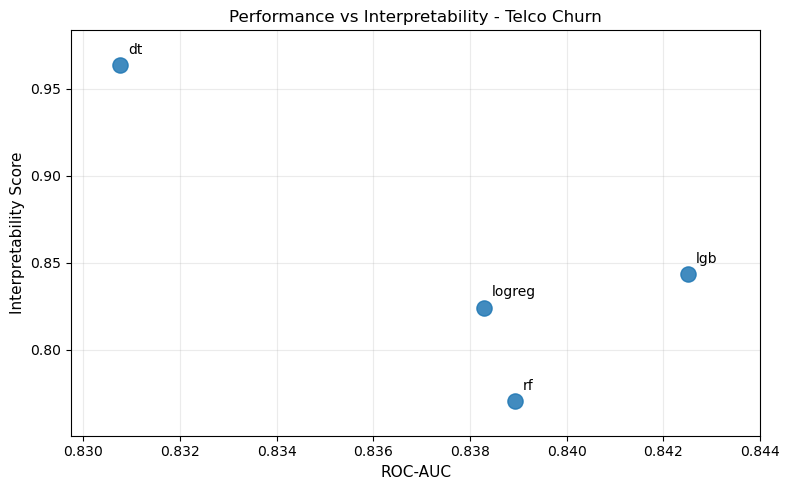

In [6]:
churn_interp = interpretability_score(churn_results["mean_stability"], churn_results["mean_sparsity"])

plt.figure(figsize=(8,5))
plt.scatter(churn_results["roc_auc"], 
            churn_interp,
            s=120,
            alpha=0.85
        )

for i, model in enumerate(churn_results["model"]):
    plt.annotate(
        text = model,
        xy = (churn_results["roc_auc"][i], churn_interp[i]),
        xytext=(6, 6),
        textcoords="offset points",
        fontsize=10,
        ha="left",
        va="bottom"
    )

plt.xlim(min(churn_results["roc_auc"]) - 0.001,
         max(churn_results["roc_auc"]) + 0.0015)
plt.ylim(min(churn_interp) - 0.02,
         max(churn_interp) + 0.02)

plt.grid(alpha=0.25)
plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Telco Churn", fontsize=12)

plt.tight_layout()
plt.show()

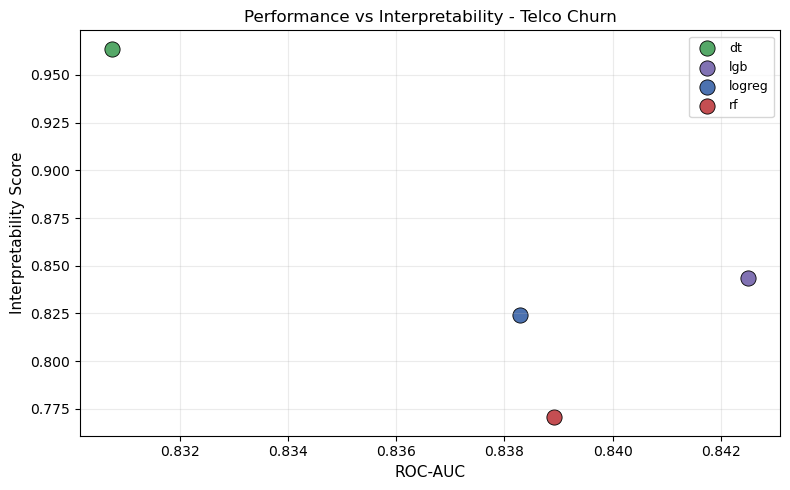

In [7]:
model_colors = {
    "logreg": "#4C72B0",  # muted blue
    "dt": "#55A868",        # muted green
    "rf": "#C44E52",        # muted red
    "lgb": "#8172B3"              # muted purple
}

plt.figure(figsize=(8,5))

for model in churn_results["model"]:
    mask = churn_results["model"] == model
    plt.scatter(
        churn_results.loc[mask, "roc_auc"],
        churn_interp[mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Telco Churn", fontsize=12)

plt.tight_layout()
plt.savefig("figures/telco_scatter.png", dpi=300)
plt.show()

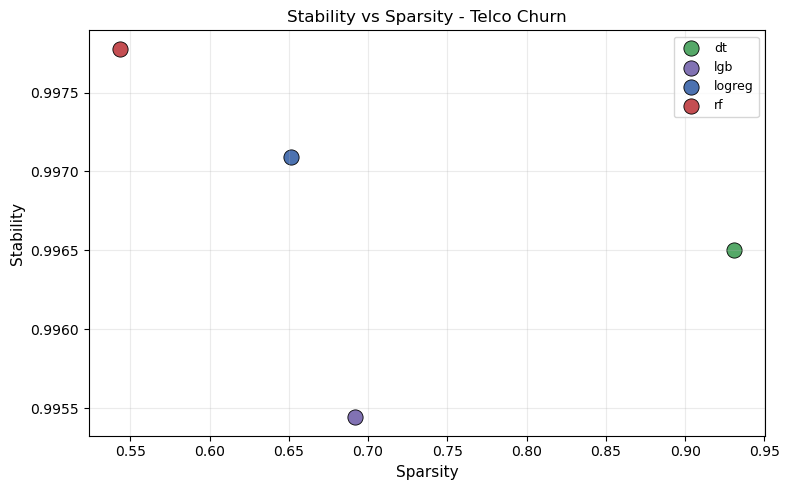

In [8]:
plt.figure(figsize=(8,5))

for model in churn_results["model"]:
    mask = churn_results["model"] == model
    plt.scatter(
        churn_results.loc[mask, "mean_sparsity"],
        churn_results["mean_stability"][mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("Sparsity", fontsize=11)
plt.ylabel("Stability", fontsize=11)
plt.title("Stability vs Sparsity - Telco Churn", fontsize=12)

plt.tight_layout()
plt.savefig("figures/stability_sparsity/telco_scatter.png", dpi=300)
plt.show()

### Breast Cancer

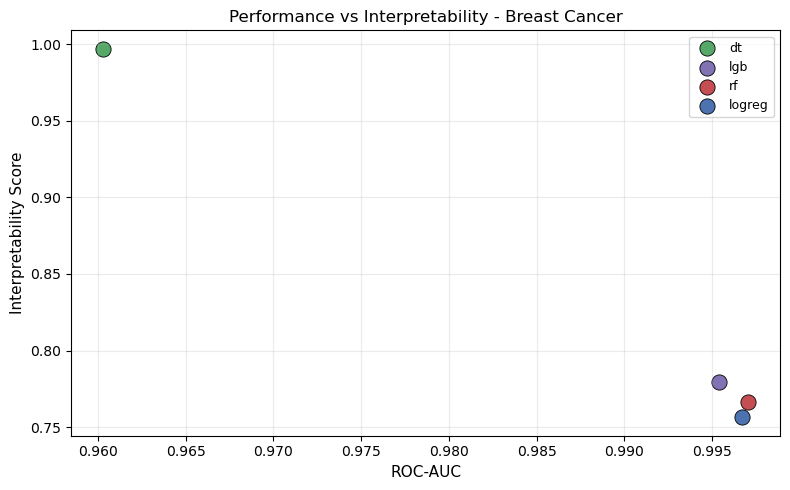

In [9]:
bc_interp = interpretability_score(bc_results["mean_stability"], bc_results["mean_sparsity"])

plt.figure(figsize=(8,5))

for model in bc_results["model"]:
    mask = bc_results["model"] == model
    plt.scatter(
        bc_results.loc[mask, "roc_auc"],
        bc_interp[mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Breast Cancer", fontsize=12)

plt.tight_layout()
plt.savefig("figures/breast_cancer_scatter.png", dpi=300)
plt.show()

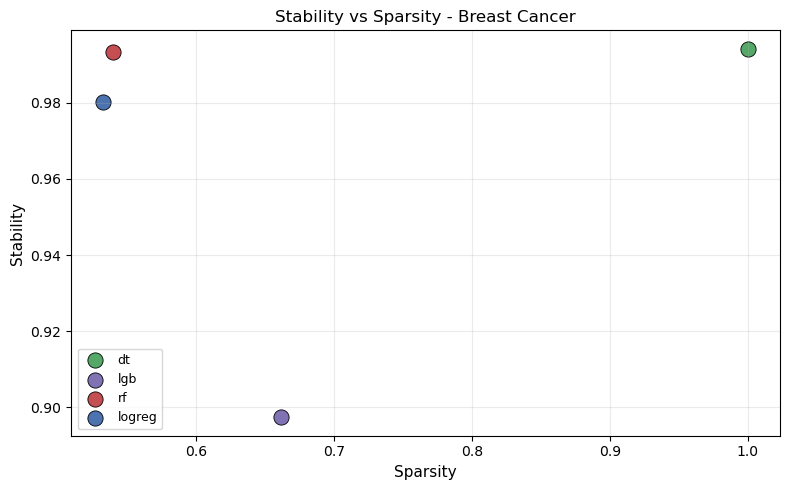

In [10]:
plt.figure(figsize=(8,5))

for model in bc_results["model"]:
    mask = bc_results["model"] == model
    plt.scatter(
        bc_results.loc[mask, "mean_sparsity"],
        bc_results["mean_stability"][mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("Sparsity", fontsize=11)
plt.ylabel("Stability", fontsize=11)
plt.title("Stability vs Sparsity - Breast Cancer", fontsize=12)

plt.tight_layout()
plt.savefig("figures/stability_sparsity/breast_cancer_scatter.png", dpi=300)
plt.show()

### Statlog (German Credit Data)

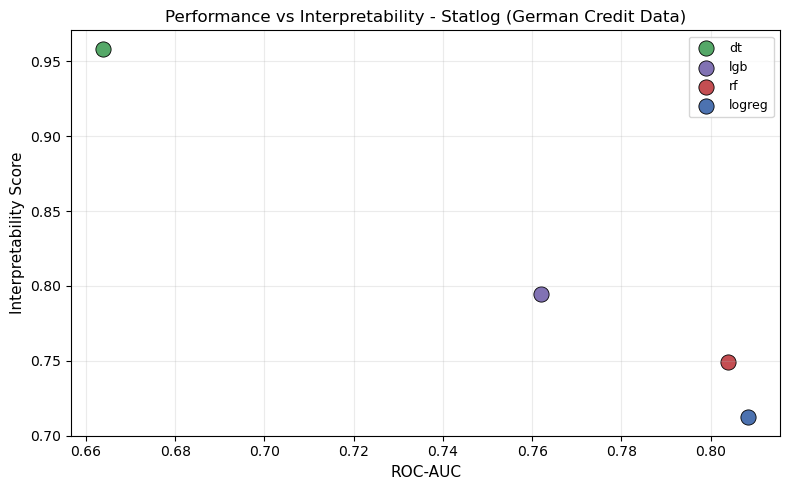

In [11]:
credit_interp = interpretability_score(credit_results["mean_stability"], credit_results["mean_sparsity"])

plt.figure(figsize=(8,5))

for model in credit_results["model"]:
    mask = credit_results["model"] == model
    plt.scatter(
        credit_results.loc[mask, "roc_auc"],
        credit_interp[mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Statlog (German Credit Data)", fontsize=12)

plt.tight_layout()
plt.savefig("figures/credit_scatter.png", dpi=300)
plt.show()

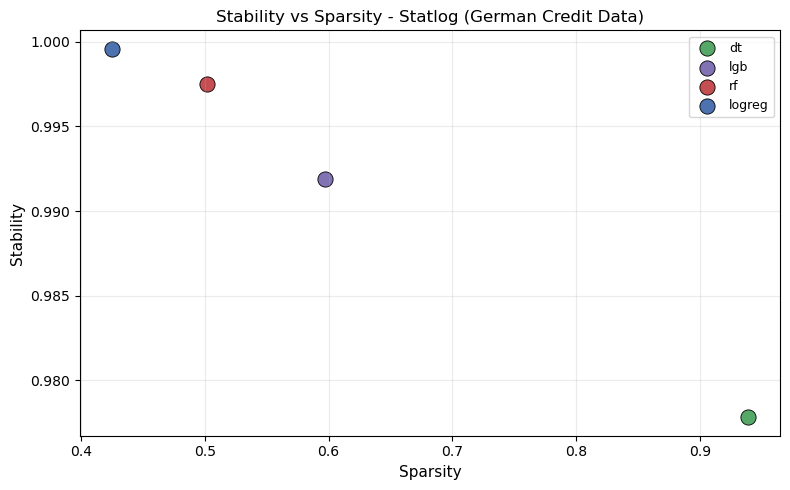

In [12]:
plt.figure(figsize=(8,5))

for model in credit_results["model"]:
    mask = credit_results["model"] == model
    plt.scatter(
        credit_results.loc[mask, "mean_sparsity"],
        credit_results["mean_stability"][mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("Sparsity", fontsize=11)
plt.ylabel("Stability", fontsize=11)
plt.title("Stability vs Sparsity - Statlog (German Credit Data)", fontsize=12)

plt.tight_layout()
plt.savefig("figures/stability_sparsity/credit_scatter.png", dpi=300)
plt.show()

### Wine Quality


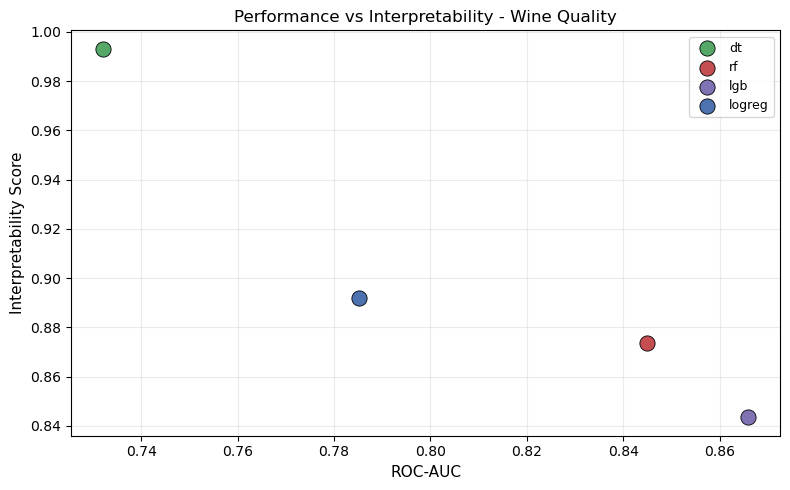

In [13]:
wine_interp = interpretability_score(wine_results["mean_stability"], wine_results["mean_sparsity"])

plt.figure(figsize=(8,5))

for model in wine_results["model"]:
    mask = wine_results["model"] == model
    plt.scatter(
        wine_results.loc[mask, "roc_auc"],
        wine_interp[mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Wine Quality", fontsize=12)

plt.tight_layout()
plt.savefig("figures/wine_scatter.png", dpi=300)
plt.show()

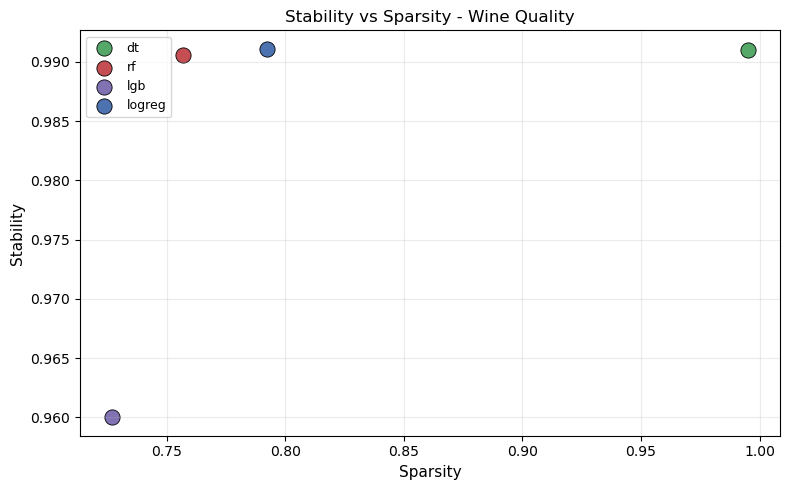

In [14]:
plt.figure(figsize=(8,5))

for model in wine_results["model"]:
    mask = wine_results["model"] == model
    plt.scatter(
        wine_results.loc[mask, "mean_sparsity"],
        wine_results["mean_stability"][mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("Sparsity", fontsize=11)
plt.ylabel("Stability", fontsize=11)
plt.title("Stability vs Sparsity - Wine Quality", fontsize=12)

plt.tight_layout()
plt.savefig("figures/stability_sparsity/wine_scatter.png", dpi=300)
plt.show()

### Glass Identification

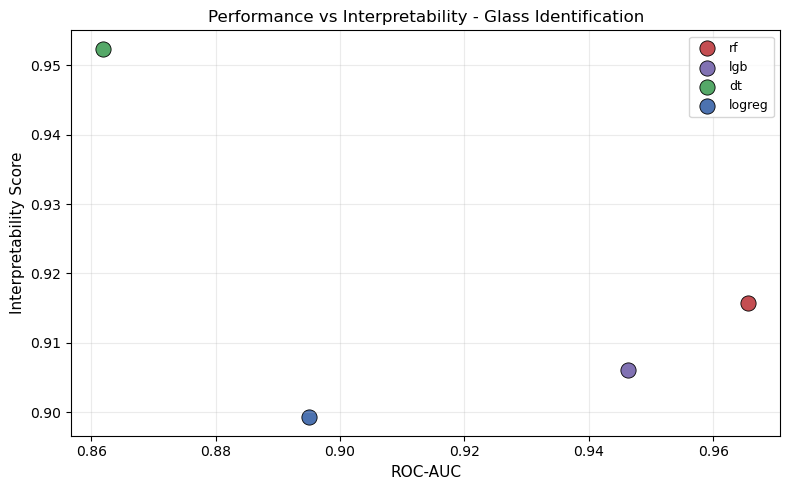

In [15]:
glass_interp = interpretability_score(glass_results["mean_stability"], glass_results["mean_sparsity"])

plt.figure(figsize=(8,5))

for model in glass_results["model"]:
    mask = glass_results["model"] == model
    plt.scatter(
        glass_results.loc[mask, "roc_auc"],
        glass_interp[mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("ROC-AUC", fontsize=11)
plt.ylabel("Interpretability Score", fontsize=11)
plt.title("Performance vs Interpretability - Glass Identification", fontsize=12)

plt.tight_layout()
plt.savefig("figures/glass_scatter.png", dpi=300)
plt.show()

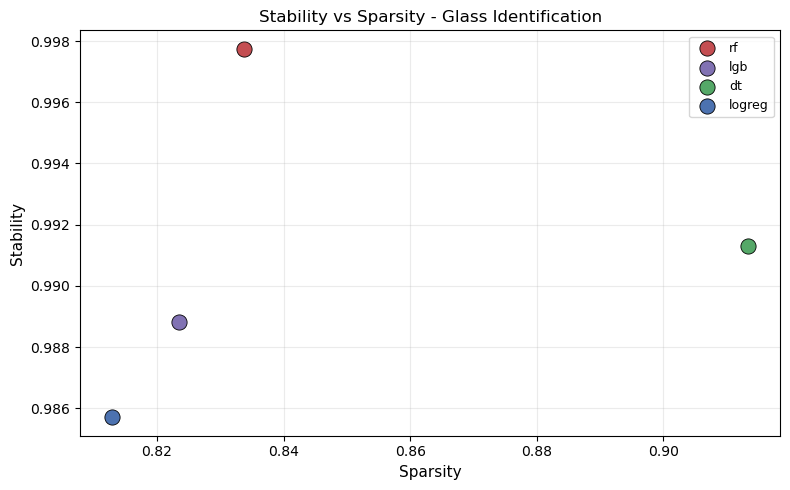

In [16]:
plt.figure(figsize=(8,5))

for model in glass_results["model"]:
    mask = glass_results["model"] == model
    plt.scatter(
        glass_results.loc[mask, "mean_sparsity"],
        glass_results["mean_stability"][mask],
        s=120,
        label = model,
        color=model_colors[model],
        edgecolor="black",
        linewidth=0.6
    )

plt.legend(frameon=True, fontsize=9)
plt.grid(alpha=0.25)

plt.xlabel("Sparsity", fontsize=11)
plt.ylabel("Stability", fontsize=11)
plt.title("Stability vs Sparsity - Glass Identification", fontsize=12)

plt.tight_layout()
plt.savefig("figures/stability_sparsity/glass_scatter.png", dpi=300)
plt.show()

### Alpha sensitivity on Wine Quality dataset

In [41]:
# redefine scoring function
def multi_objective_score_plot(performance, shap_stability, shap_sparsity, perf_ratio=0.5, interp_ratio = 0.5):
    
    interp = interp_ratio * shap_stability + (1 - interp_ratio) * shap_sparsity

    return perf_ratio * performance + (1-perf_ratio) * interp

In [52]:
performance = wine_results["roc_auc"]
stability = wine_results["mean_stability"]
sparsity = wine_results["mean_sparsity"]

wine_ranking_score = {}

for i in np.round(np.linspace(0, 1, 6), 2):
    ranking_score = multi_objective_score_plot(performance=performance, 
                                               shap_stability=stability, 
                                               shap_sparsity=sparsity, 
                                               perf_ratio=i,
                                               interp_ratio=0.5
                                              )
    
    wine_ranking_score[i] = np.asarray(ranking_score, dtype=float)  # force no index alignment
    


In [53]:
wine_ranking_df = (
    pd.DataFrame(wine_ranking_score, index=wine_results["model"])
      .T
      .reset_index()
      .rename(columns={"index": "alpha"})
)

In [54]:
wine_ranking_long = wine_ranking_df.melt(id_vars="alpha",
                           var_name="model",
                           value_name="score")
wine_ranking_long

,alpha,model,score
0,0.0,dt,0.993114
1,0.2,dt,0.940927
2,0.4,dt,0.888740
3,0.6,dt,0.836552
4,0.8,dt,0.784365
5,1.0,dt,0.732177
6,0.0,rf,0.873736
7,0.2,rf,0.867971
8,0.4,rf,0.862206
9,0.6,rf,0.856442


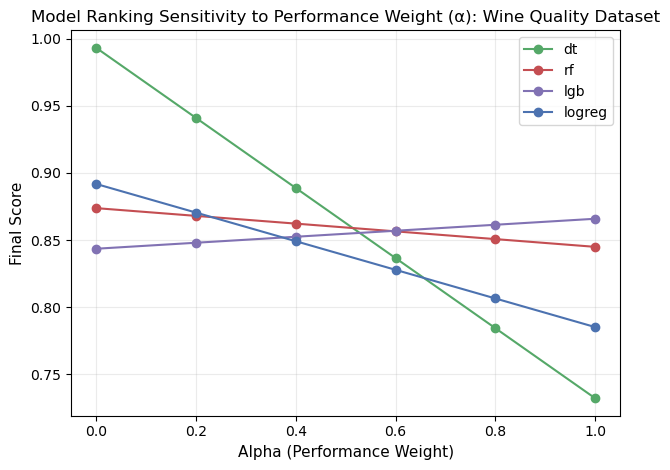

In [61]:
for model in wine_ranking_long["model"].unique():
    subset = wine_ranking_long[wine_ranking_long["model"] == model]
    plt.plot(subset["alpha"], subset["score"], marker="o", label=model, color=model_colors[model])

plt.legend()
plt.grid(alpha=0.25)

plt.xlabel("Alpha (Performance Weight)", fontsize=11)
plt.ylabel("Final Score", fontsize=11)
plt.title("Model Ranking Sensitivity to Performance Weight (α): Wine Quality Dataset", fontsize=12)

plt.tight_layout()
plt.savefig("figures/alpha_plot.png", dpi=300)
plt.show()